In [1]:
#LIBRARIES
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import json
import time
from datetime import datetime
import pydde as dde
import os

#PARAMETERS
now = datetime.now()
samplenum = 10 # numer of samples
nTimeSteps = 60 # at 60Hz
batch_size = 10 # amount of samples per file
input_size = 25 # target (0:3), q (3:9), qdot (9:15), qddot (15:21), p_now (21:25) 
threshhold2 = 0.001
samples_per_sim = 1 #samples_per_sim = int(nTimeSteps/2) # amount of states taken per generated trajectory
use_case = 'cube-drag'
filenum = int(samplenum/batch_size)
sample_file_path = f'../Data/Samples/data_cube-drag_{nTimeSteps}tsteps_' + now.strftime("%H%M") + '/'
simulation_file_path = "../Data/Simulations/cube-drag.sim"
objective_file_path = f'../Data/Objectives/cube-drag.obj'

# check dde version
print("using dde version: " + dde.__version__)
# set log level
dde.set_log_level(dde.LogLevel.off)
print(f'log level set to {dde.get_log_level()}')

# CREATE DIRECTORY FOR SAMPLES
try:
    os.mkdir(sample_file_path)
except OSError:
    print ("Creation of the directory %s failed" % sample_file_path)
else:
    print ("Successfully created the directory %s" % sample_file_path)

#SAMPLE TARGETS
print("SAMPLING STARTED...")
tot_simulations_needed = np.ceil(samplenum/samples_per_sim).astype(int)

input = np.zeros((samplenum,input_size))
targets = np.zeros((tot_simulations_needed,3))
targets[:,0] = np.random.rand(tot_simulations_needed)/2
targets[:,1] = 0.0268342693608721
targets[:,2] = np.random.rand(tot_simulations_needed)/2

############################################
#LOAD SIMULATION PYDDE_V2
dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)
p_init_0 = np.zeros(dyn.p0.size*nTimeSteps)
for i in range(0,nTimeSteps):
	p_init_0[i*dyn.p0.size : (i+1)*dyn.p0.size] = dyn.p0
state_init = dyn.q(p_init_0)
r = dyn.r(state_init, p_init_0)
dr = dyn.dr_dp(state_init, p_init_0)
dq = dyn.dq_dp(state_init, p_init_0)

#############################################
#GENERATE OPTIMIZATION
opt = dde.Newton()
opt.maxIterations = 1

using dde version: v0.1.2-20-g1cc6119-dirty
log level set to LogLevel.off
Successfully created the directory ../Data/Samples/data_cube-drag_60tsteps_1429/
SAMPLING STARTED...


In [2]:
####################################
#SAMPLE STATES
# target (0:3), q (3:9), qdot (9:15), qddot (15:21), p_now (21:25) 
p_init = p_init_0
start_time = time.time()
print("SAMPLING INITIAL STATES...")
dyn_json = json.load(open(simulation_file_path))
objective_json = json.load(open(objective_file_path))
for i in range(tot_simulations_needed):
    #load objective
    obj = dde.InverseObjective(dyn)
    objective_json["objectives"]["rbTargetPositions"][0]["timeIndex"] = nTimeSteps-1
    objective_json["objectives"]["rbTargetPositions"][0]["targetPos"][0] = [targets[i,0]]
    objective_json["objectives"]["rbTargetPositions"][0]["targetPos"][1] = [targets[i,1]]
    objective_json["objectives"]["rbTargetPositions"][0]["targetPos"][2] = [targets[i,2]]
    obj.loadJson(objective_json)

    #Trajectory Optimization
    g = 0
    u =0
    u2=0
    broken_indices =[]
    residual = 1    
    while residual > 0.001:
        u=u+1
        p_i = opt.minimize(obj, p_init)
        p_init = p_i
        #print(f'iteration{g} with residual {opt.lastResidual}')
        g = g+1
        if g == 300:
            #change starting position to initial position
            dyn = dde.DynamicSequence()
            dyn.loadFile(simulation_file_path, nTimeSteps)
            p_init = p_init_0
            obj = dde.InverseObjective(dyn)
            objective_json["objectives"]["rbTargetPositions"][0]["timeIndex"] = nTimeSteps-1
            objective_json["objectives"]["rbTargetPositions"][0]["targetPos"][0] = [targets[i,0]]
            objective_json["objectives"]["rbTargetPositions"][0]["targetPos"][1] = [targets[i,1]]
            objective_json["objectives"]["rbTargetPositions"][0]["targetPos"][2] = [targets[i,2]]           
            obj.loadJson(objective_json)
            broken_indices.append(i)
        residual = obj.evaluate(p_i)
        if g == 400:
            u2=u2+1
            residual = -1

    state_i = dyn.q(p_i)
    n_q = np.floor(dyn.nDofs*nTimeSteps/samples_per_sim).astype(int)
    n_p = np.floor(dyn.nParameters*nTimeSteps/samples_per_sim).astype(int)
    
    input[i*samples_per_sim,3:9] = dyn.q0
    input[i*samples_per_sim,9:15] = dyn.qdot0
    input[i*samples_per_sim,15:21] = dyn.qddot0
    input[i*samples_per_sim,21:25] = dyn.p0

    for l in range(dyn.nDofs):
        dyn_json["simulation"]["q"][l] = [state_i.q[dyn.nDofs*nTimeSteps-dyn.nDofs+l]]
        dyn_json["simulation"]["qdot"][l] = [state_i.qdot[dyn.nDofs*nTimeSteps-dyn.nDofs+l]]
        dyn_json["simulation"]["qddot"][l] = [state_i.qddot[dyn.nDofs*nTimeSteps-dyn.nDofs+l]]
    for l2 in range(dyn.nParameters):
        dyn_json["simulation"]["p"][l2] = [p_i[dyn.nParameters*nTimeSteps-dyn.nParameters+l2]]

    dyn.loadJson(dyn_json, nTimeSteps)
    dyn.p0 = p_i[-dyn.nParameters:]
    for s_1 in range(nTimeSteps):
        p_init[s_1*dyn.p0.size : (s_1+1)*dyn.p0.size] = dyn.p0
    if i%(tot_simulations_needed/10) == 0:
        print(f'{(time.time() - start_time)/60} simulation number {i} complete')
print(f'Jumped to initial state due to high error {u} times')
print(f'Terminated off optimization due to high error {u2} times')
print(f'TOTAL TIME TO SAMPLE STARTIG STATES: {(time.time() - start_time)/60}')
print(broken_indices)

SAMPLING INITIAL STATES...
0.0029017011324564616 simulation number 0 complete
0.016697486241658527 simulation number 1 complete
0.028390268484751385 simulation number 2 complete
0.03480972051620483 simulation number 3 complete
0.05045695304870605 simulation number 4 complete
0.05728456974029541 simulation number 5 complete
0.06687255303064982 simulation number 6 complete
0.07202563683191936 simulation number 7 complete
0.07921377023061117 simulation number 8 complete
0.08298125267028808 simulation number 9 complete
Jumped to initial state due to high error 1 times
Terminated off optimization due to high error 0 times
TOTAL TIME TO SAMPLE STARTIG STATES: 0.08299838304519654
[]


In [4]:
###############################################
#SAMPLE NEW TARGETS
print("SAMPLING NEW TARGETS...")
input[:,0] = np.random.rand(samplenum)/2
input[:,1] = 0.0268342693608721
input[:,2] = np.random.rand(samplenum)/2
p_init = p_init_0

###############################################
#SAMPLE CONTROLS
print("SAMPLING CONTROLS...")
c=0 # counter for how often the error is too high

for b in range(filenum):
    data = {}
    data['p'] = []
    data['q_target'] = []
    data['q'] = []
    data['qdot'] = []
    data['qddot'] = []
    data['p_now'] = []
    data['loss'] = []
    data['iterations'] = []
    data['lineSearchIterations'] = []

    for i_2 in range(batch_size):
        #Change DynamicSequence
        for l in range(dyn.nDofs):
            dyn_json["simulation"]["q"][l] = [input[b*batch_size+i_2,3+l]] 
            dyn_json["simulation"]["qdot"][l] = [input[b*batch_size+i_2,9+l]] 
            dyn_json["simulation"]["qddot"][l] = [input[b*batch_size+i_2,15+l]] 
        for l in range(dyn.nParameters):
            dyn_json["simulation"]["p"][l] = [input[b*batch_size+i_2,21+l]] 
        dyn.loadJson(dyn_json, nTimeSteps)
        dyn.p0 = input[b*batch_size+i_2,21:25]
        for s in range(nTimeSteps):
            p_init[s*dyn.p0.size : (s+1)*dyn.p0.size] = dyn.p0
        #Change Objective
        obj = dde.InverseObjective(dyn)
        objective_json["objectives"]["rbTargetPositions"][0]["timeIndex"] = nTimeSteps-1
        objective_json["objectives"]["rbTargetPositions"][0]["targetPos"] = ([[input[b*batch_size+i_2,0]],[input[b*batch_size+i_2,1]],[input[b*batch_size+i_2,2]]]) 
        obj.loadJson(objective_json)

        #Trajectory Optimization
        g = 0
        residual2 = 1
        iterations = 0
        linesearch = 0
        while residual2 > threshhold2:
            p_i = opt.minimize(obj, p_init)
            p_init = p_i
            #print(f'iteration {g} with residual {opt.lastResidual}')
            g = g+1
            residual2 = obj.evaluate(p_i)
            if g == 400:
                c = c+1
                input[b*batch_size+i_2,:]=0
                residual2 = 0

        #Store the Data
        data['q_target'].append(list(input[b*batch_size+i_2,0:3]))
        data['q'].append(list(input[b*batch_size+i_2,3:9]))
        data['qdot'].append(list(input[b*batch_size+i_2,9:15]))
        data['qddot'].append(list(input[b*batch_size+i_2,15:21]))
        data['p_now'].append(list(input[b*batch_size+i_2,21:25]))
        data['p'].append(list(p_i))
        data['loss'].append(residual2)
        data['iterations'].append(opt.getLastIterations())
        data['lineSearchIterations'].append(opt.lastLineSearchIterations)

    with open(sample_file_path + f'data_{b}.json', 'w') as outfile:
        json.dump(data, outfile)
    print(f'batch number {b+1} completed')
    print(f'\nDuration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed
    
#add description file
Description = {}
Description['Description'] = [{'samplenum': samplenum, 'samplesperfile': batch_size, 'time length': nTimeSteps, 'sample space': "x- and y-direction 0 to 0.5"}]
with open(sample_file_path + 'Description.json', 'w') as outfile:
    json.dump(Description, outfile)
print('SAMPLING COMPLETE.')
print(f'Failed Sample due to high error {c} times')
print(f'TOTAL TIME TO SAMPLE: {(time.time() - start_time)/60}')

SAMPLING NEW TARGETS...
SAMPLING CONTROLS...
batch number 1 completed

Duration: 40.281 min
SAMPLING COMPLETE.
Failed Sample due to high error 0 times
TOTAL TIME TO SAMPLE: 40.2808566848437


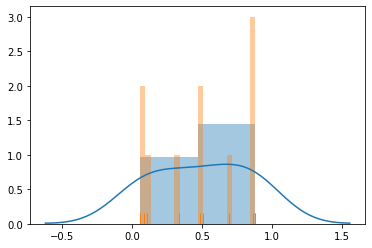

In [16]:
###############################
#PLOT DISTRIBUTION
import seaborn as sns
x = input[:, 0]
sns.distplot(x)
sns.distplot(x, bins=20, kde=False, rug=True)